# Portfolio Selection via Text-Based Networks

# 1. Data Processing


In [4]:
import numpy as np
import pandas as pd
import glob
import os
from datetime import datetime
import igraph
import cairocffi
import cairo
from numpy.linalg import inv
import matplotlib.pyplot as plt

## 1.1 Load stock information

In [6]:
file_path = '../data/'
# load TBN data
file_name = 'gvkey_ticker.csv'
tickers_info = pd.read_csv(file_path + file_name,  header=0, usecols=[1, 2], index_col = [0], engine='c')
tickers_info = tickers_info.loc[~tickers_info.index.duplicated(keep='first')]

# load stock data
file_name = 'stock_data.csv'
stock_data = pd.read_csv(file_path + file_name,  header=0, index_col=[0], engine='c')
tickers_subset = stock_data.dropna(axis='columns').columns
tickers_key = tickers_info.loc[tickers_subset].gvkey.values

# load market data
file_name = 'F-F_Research_Data_Factors_daily.csv'
interest_rate = pd.read_csv(file_path + file_name,  header=0, usecols=[0, 4], index_col=[0], engine='c').dropna()
date_format = '%Y%m%d' # Y for year, m for month, d for day
rf_date = pd.Index([datetime.strptime(str(x), date_format) for x in interest_rate.index])
interest_rate.index = rf_date

## *1.2 Extract related TBN(Needed for the first time)
Loop from 1999 to  2017, extract related info according to gvkey for each year. The resuts are going to be reformated to a 26 by 26 matrix for each year. However, HON doesn't included in TNIC network. So the final results are 25 by 25 matrix.

In [243]:
def extract_TNIC_network_subset(key_list):

        # initialization
        OUTPUT_FILE_PATH = os.getcwd() + '/' + 'data/'
        OUTPUT_FILE_TYPE = '.csv'
        TARGET_FOLDER_PATH = "/Users/cheng/Documents/Research/Text Base Network/tnic_all_data/TNIC_AllPairsDistrib/"
        TARGET_FILE_TYPE = "*.txt"
        file_list = glob.glob(TARGET_FOLDER_PATH + TARGET_FILE_TYPE)
        idx = pd.IndexSlice


        for file in file_list:

                # read data
                data = pd.read_csv(file, sep="\t", header=0, usecols=[0, 1, 2], index_col=[1, 2], engine='c')
                
                # extract selected data
                scores_year = data.loc[idx[key_list, key_list], ] # a long vector

                # modification
                scores_year = scores_year.unstack() # convert vector to matrix
                scores_year.columns.names = [None,None] # clear multi column index 
                scores_year.index.names = [None] # clear index head name
                scores_year.columns = scores_year.index 
                np.fill_diagonal(scores_year.values, 1) # fill diagnoal with value 1
                scores_year = scores_year.replace([np.NaN], 0)

                # save data
                if not os.path.exists(OUTPUT_FILE_PATH):
                        os.makedirs(OUTPUT_FILE_PATH)
                
                IDENTIFIER =file.split('/')[-1][-8:-4]
                scores_year.to_csv(OUTPUT_FILE_PATH + IDENTIFIER + OUTPUT_FILE_TYPE)


In [244]:
extract_TNIC_network_subset(tickers_key)

## 1.3 Load TBN data


In [12]:
def get_text_based_network(year):
    
    year_str = str(year)
    TARGET_FOLDER_PATH = "../data/"
    TARGET_FILE_TYPE = "TBN_*.csv"
    file_list = glob.glob(TARGET_FOLDER_PATH + TARGET_FILE_TYPE)

    file_idx = [year_str in x for x in file_list]
    file_path = np.array(file_list)[file_idx] # np.array index using bool vector
    data = pd.read_csv(file_path[0], header=0, index_col=[0], engine='c')

    return(data)


# 2 Networks
## 2.1 Correlation-Based Networks
**Data processing at first**

In [7]:
# Na value
stock_data = stock_data.dropna(axis='columns') # drop incomplete data to form 26 columns

# set year as index 
date_format = '%Y-%m-%d' # Y for year, m for month, d for day
stock_date = pd.Index([datetime.strptime(x, date_format) for x in stock_data.index])
stock_data.index = [x.year for x in stock_date]

# calculate stock returns
stock_returns = stock_data.pct_change().dropna(axis='rows')

**compute correlation matrix for stock return**

In [8]:
correlation_aggregate = stock_returns.groupby(level=0).corr()
volatility_aggregate = stock_returns.groupby(level=0).std()
covariance_aggregate = stock_returns.groupby(level=0).cov()

correlation_return_1996 = correlation_aggregate.loc[1996]
correlation_return_2008 = correlation_aggregate.loc[2008]

**plot adjacient graph**

In [8]:
def adjacency_plot(matrix, thredshould, output_name):
    # matrix modification
    t = thredshould
    A = matrix[matrix.abs() > t].fillna(0).values # passing a np array

    # build graph
    #g = igraph.Graph.Adjacency(matrix = (A > 0).tolist(),mode='UNDIRECTED')
    g = igraph.Graph.Weighted_Adjacency(matrix = A.tolist(), mode='UNDIRECTED')
    g.es['weight'] = A
    g.vs['label'] = matrix.index

    # layout control
    visual_style = {}
    visual_style["vertex_size"] = 25
    visual_style["vertex_label_size"] = 10
    visual_style["edge_width"] = 0.5
    visual_style["autocurve"] = False
    visual_style["label"] = True
    visual_style["layout"] = 'kk'
    visual_style["bbox"] = (600, 600)
    visual_style["margin"] = 80

    # save file
    file_prefix = os.getcwd() + '/' + 'picture/'
    file_suffix = '.png'

    return(igraph.plot(g,file_prefix + output_name + file_suffix ,**visual_style)) # return a graph, no return no plot

** plot 1996 graph**

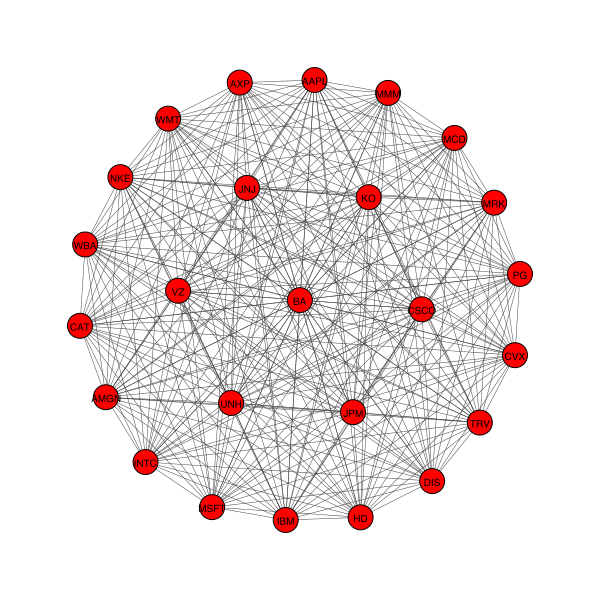

In [14]:
# input
np.fill_diagonal(correlation_return_1996.values, 0)
parameters = {}
parameters['matrix'] = correlation_return_1996
parameters['thredshould'] = 0
parameters['output_name'] = 'stock_return_correlation_network_1996'

# output
adjacency_plot(**parameters)

**plot 2008 plot**

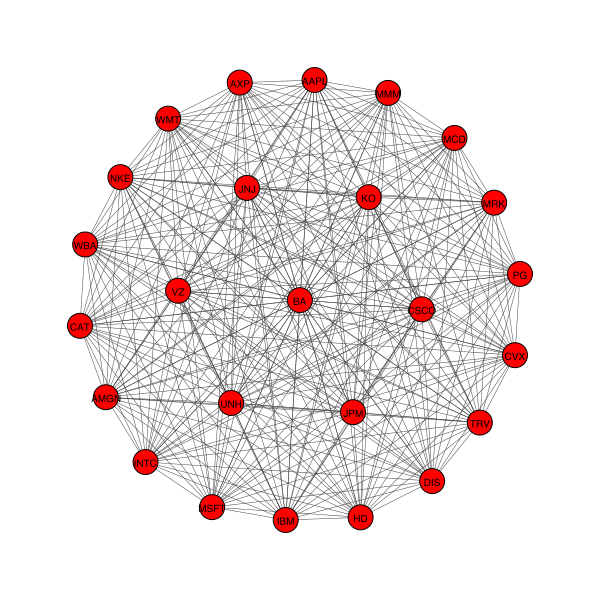

In [15]:
# input
np.fill_diagonal(correlation_return_2008.values, 0)
parameters = {}
parameters['matrix'] = correlation_return_2008
parameters['thredshould'] = 0
parameters['output_name'] = 'stock_return_correlation_network_2008'

# output
adjacency_plot(**parameters)

** Remove all correlation below 0.5**

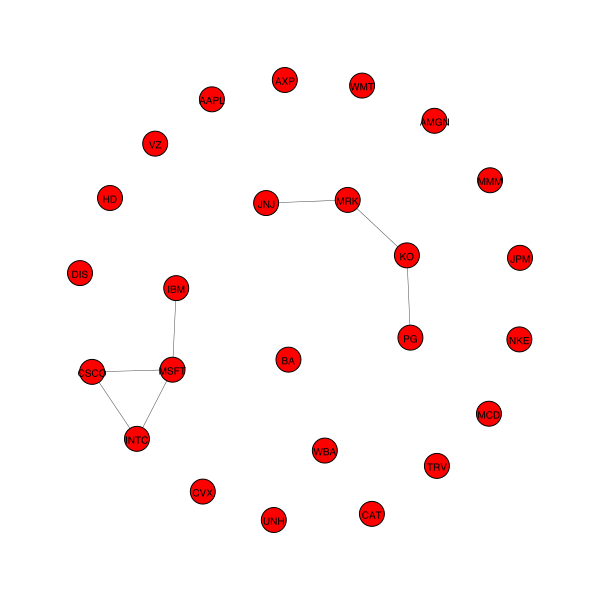

In [22]:
# input
parameters = {}
parameters['matrix'] = correlation_return_1996
parameters['thredshould'] = 0.5
parameters['output_name'] = 'stock_return_correlation_network_1996_parse_2'

# output
adjacency_plot(**parameters)

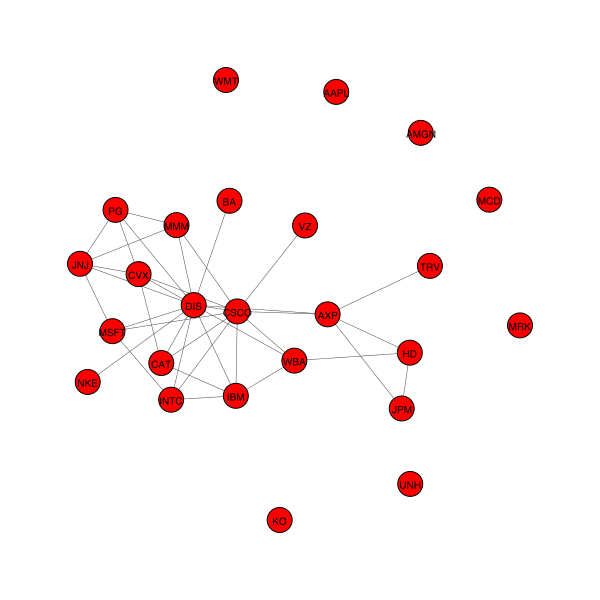

In [24]:
# input
parameters = {}
parameters['matrix'] = correlation_return_2008
parameters['thredshould'] = 0.7
parameters['output_name'] = 'stock_return_correlation_network_2008_parse_2'

# output
adjacency_plot(**parameters)

## 2.2 Text-Based Networks

In [26]:
correlation_text_1996 = get_text_based_network(1996)
correlation_text_2008 = get_text_based_network(2008)

correlation_text_1996.index = correlation_return_1996.index
correlation_text_2008.index = correlation_return_1996.index
np.fill_diagonal(correlation_text_1996.values, 0)
np.fill_diagonal(correlation_text_2008.values, 0)


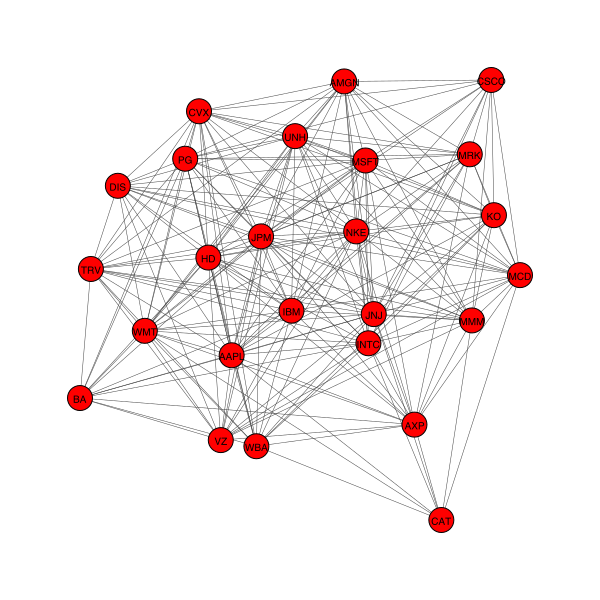

In [34]:
# input
parameters = {}
parameters['matrix'] = correlation_text_1996
parameters['thredshould'] = 0
parameters['output_name'] = 'text_correlation_network_1996'

# output
adjacency_plot(**parameters)

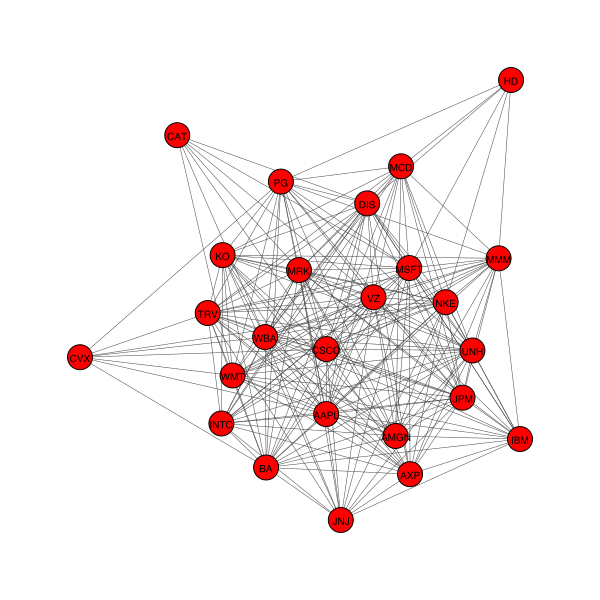

In [33]:
# input
parameters = {}
parameters['matrix'] = correlation_text_2008
parameters['thredshould'] = 0
parameters['output_name'] = 'text_correlation_network_2008'

# output
adjacency_plot(**parameters)

# 3. Back-testing
**Buid the GMV portfolio as a function of intensity $\alpha$**

In [21]:
def GMVP(a, correlated_matrix_stock, correlated_matrix_text, volatility_vector):
    '''GMV portfolio as a function of intensity 'alpha'
    Args:
        a: alpha
        correlated_matrix_stock: correlation matrix of stock returns
        correlated_matrix_text: TBN
        volatility_vector: volatility of stock returns
    Returns:
        GMVP(column vector)
    '''
    # initialization
    R_1 = correlated_matrix_stock.values
    R_2 = correlated_matrix_text.values
    D = np.diag(volatility_vector) 
    one = np.ones(D.shape[0])

    # pre calculation
    R_3 = (1 - a) * R_1 + a * R_2 # new shrank correlated matrix
    H = D @ R_3 @ D # new shrank covariance matrix
    H_inv = inv(H)
    numerator = H_inv @ one
    denominator = one.T @ H_inv @ one

    # GMV porfolio
    x = numerator / denominator

    #return pd.DataFrame(H)
    return x.reshape((len(x), 1))

**build back testing function**

In [156]:
def back_test_on_portfolio_return(start, end, alpha_step):
    '''Build GMVP at the end of each year and compute portfolio return on the next year

    Required function:
        GMVP - calculate portfolio weights
        get_text_based_network - need for GMVP
    Args:
        start: beginning year
        end: ending year
        alpha_step: increment step for alpha range
    Returns:
        daily portfolio return time series
        n * 252 time series (n: # of alpha range)
    '''

    # initialization
    year_range = np.arange(start, end + 1)
    alpha_range = np.arange(0, 1 + alpha_step, alpha_step)
    INFO = pd.DataFrame()
    portfolio = pd.DataFrame()

    for alpha in alpha_range:
        
        R_p = np.array([]) # to store portfolio's return series for each alpha
        gmv_p = np.array([])

        for i in year_range:

            # calculate GMV portfolio
            parameter_list = {}
            parameter_list['a'] = alpha
            parameter_list['correlated_matrix_stock'] = correlation_aggregate.loc[i]
            parameter_list['correlated_matrix_text'] = get_text_based_network(i)
            parameter_list['volatility_vector'] = volatility_aggregate.loc[i]
            x = GMVP(**parameter_list).T # 1 by n row vector
            
            # get stock return for the next year
            Y = stock_returns.loc[i + 1].values.T # n by 252 matrix
            #index = stock_returns.loc[i + 1].index

            # compute portfolio return for the next year
            r_p = x @ Y

            # store return series
            R_p = np.append(R_p, r_p)
            #gmv_p = np.append(gmv_p, correlation_stock_i.iloc[0,0])

        INFO[str(alpha)] = R_p
        #portfolio[str(alpha)] = gmv_p

    # index return series with date
    start = stock_date.searchsorted(datetime(start + 1, 1, 1))
    end = stock_date.searchsorted(datetime(end + 2, 1, 1))
    #date_index = stock_date[start:end][0:INFO.shape[0]]
    date_index = stock_date[start:end]
    INFO.index = date_index

    return INFO

**Build function to compute Sharpe Ratio**

In [82]:
def sharpe_ratio(stock_return):
    '''Given portfolio daily returns to calculate Sharpe ratio

    Argument:
        stock_return: a matrix that each column reperents a time series given specific portfolio
    Requirement:
        interest_rate matrix as risk free rate

    '''

    # initialization
    date_idx = stock_return.index
    r_f = interest_rate.loc[date_idx].values.flatten()
    alpha_range = return_series.shape[1]
    sharpe_ratio_series = {} # SR container

    for i in np.arange(0, alpha_range):

        # initialization
        return_list = return_series.iloc[:,i]
        alpha = return_list.name
        
        # calculate annual SR
        excess_return = return_list - r_f * 0.01
        expected_return = excess_return.mean() * 252
        volatility = excess_return.std()* np.sqrt(252)
        sharpe_ratio = expected_return / volatility
        
        # store SR
        sharpe_ratio_series[alpha] = sharpe_ratio

    temp = pd.DataFrame(sharpe_ratio_series, index=['SR']).T
    return temp


**Build plot function to visulize Sharpe ratio as a function of $\alpha$**

In [190]:
def sharpe_ratio_show(vector, title):
    # initialization
    output_path = '../picture/'
    output_name = output_path + title + '.jpg'

    # plot
    fig = plt.figure()
    vector.plot.line()
    plt.title(title)
    plt.ylabel('Annual Sharpe Ratio')
    plt.xlabel('$\\alpha$ range')
    #fig.savefig(output_name)
    plt.show()

** Back testing on different periods**

In [270]:
SR_aggregate = pd.DataFrame()

<Figure size 432x288 with 0 Axes>

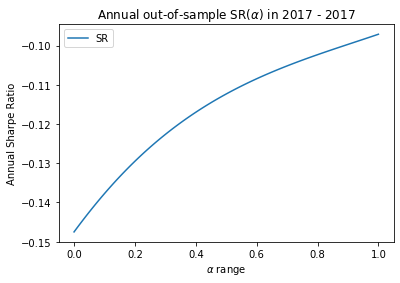

In [292]:
year += 1
parameter_list = {}
parameter_list['start'] = year
parameter_list['end'] = year
parameter_list['alpha_step'] = 0.01

# calculate portfolio return for different alpha
return_series = back_test_on_portfolio_return(**parameter_list)

# calculate Sharpe ratio for different alpha
SR = sharpe_ratio(return_series)

# store
SR_aggregate[year] = SR.values.flatten()

# plot Sharpe ratio as a function of alpha
file_name = 'Annual out-of-sample SR($\\alpha$) in ' + str(parameter_list['start']) + ' - ' + str(parameter_list['end'])
sharpe_ratio_show(SR, file_name)

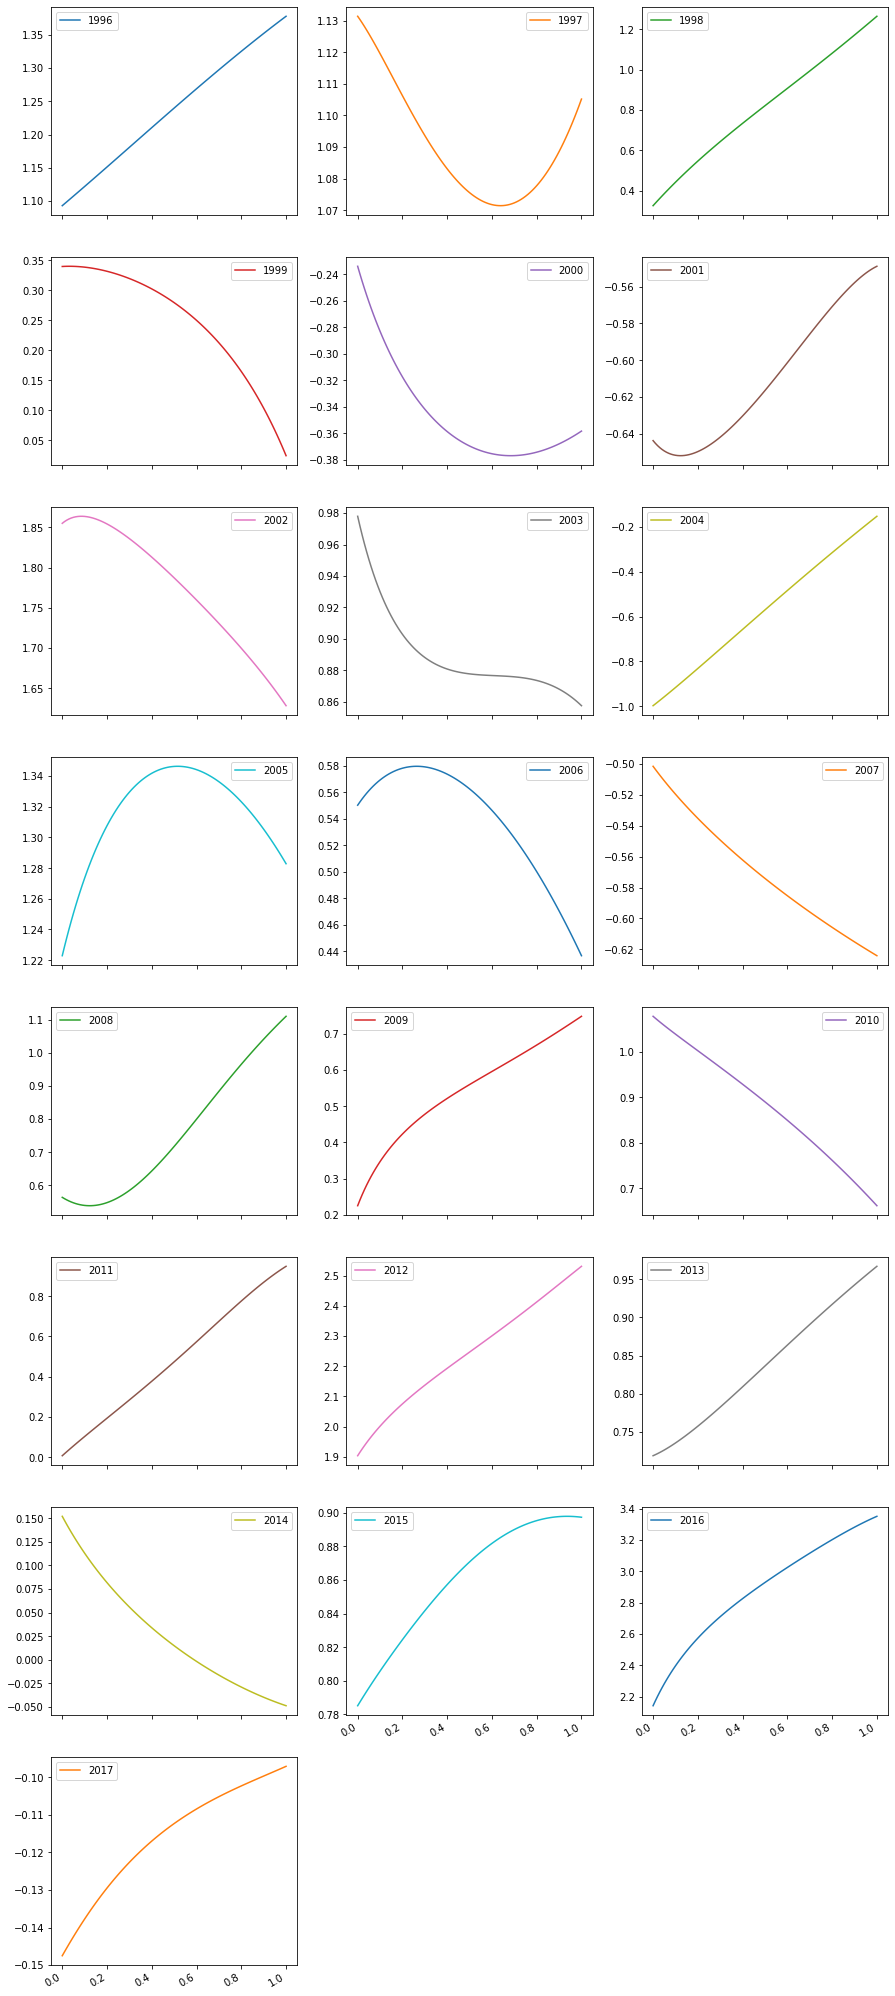

In [349]:
index = np.arange(0, 1.01, 0.01)
SR_aggregate.index = index
xtickers = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
title = 'Sharpe ratio SR($\\alpha$) on years from 1996 to 2017'
fig = SR_aggregate.plot(subplots = True,
                        use_index = True,
                        xticks = xtickers,
                        fontsize = 10,
                        layout = (8,3), 
                        figsize = (15,40))

In [338]:
sharpe_ratio_optimums = SR_aggregate.idxmax(axis=0)

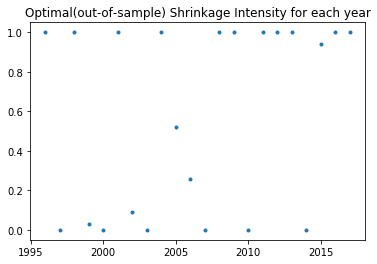

In [341]:
test = sharpe_ratio_optimums.plot(style = '.',
                           title = 'Optimal(out-of-sample) Shrinkage Intensity for each year')

test.figure.savefig('../picture/Optimal(out-of-sample) Shrinkage Intensity for each year.jpg')

# Note

In [162]:
x.index.names = [None]

In [166]:
x.columns.names = [None,None]

In [169]:
x.columns = x.index


In [121]:
data_2013 = pd.read_csv(file_list[12], header=0, sep="\t", usecols=[0, 1, 2], index_col=[1, 2], engine='c')


In [ ]:
x = x.unstack()
